In [1]:
from torchtext.data.utils import get_tokenizer
import pickle
import os
import numpy as np
import numpy as np
import pickle
import collections
from scipy.stats import spearmanr
import itertools
import torch
import seaborn as sns
import random
import matplotlib.pyplot as plt
import torch.nn.functional as F
from scipy.spatial import distance
import numpy as np
import pickle
from torchvision.datasets import VOCSegmentation
from scipy.stats import spearmanr, pearsonr, rankdata
import itertools
from scipy.special import comb
import collections
import scipy
from scipy.stats import sem
import pandas as pd
import seaborn as sns
import torchvision.transforms as T
import matplotlib.pyplot as plt

In [2]:
voc_ds = VOCSegmentation(
    './VOC',
    year='2012',
    image_set='train',
    download=False,
    transform=T.Compose([
        T.ToTensor(),
        T.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )    
    ]),
    target_transform=T.Lambda(
        lambda p: torch.tensor(p.getdata()).view(1, p.size[1], p.size[0])
    )
)

In [3]:
lime_exs = pickle.load(open("limes.pkl", "rb"))
shap_exs = pickle.load(open("shaps.pkl", "rb"))



In [6]:
#rank correlation

def rankcorr(attrA, attrB):
    '''
    attrA: np.array, n x p
    attrB: np.array, n x p
    '''
    corrs = []
    
    for row in range(len(attrA)) : #.shape[0]):
        all_feat_ranksA = rankdata(-np.abs(attrA[row]), method='dense')
        all_feat_ranksB = rankdata(-np.abs(attrB[row]), method='dense')
        rho, _ = pearsonr(all_feat_ranksA, all_feat_ranksB) 
        corrs.append(rho)
  
    return np.array(corrs), np.mean(corrs) #return metric's distribution and average





In [7]:
def pairwise_comp(attrA, attrB):
    
    '''
    inputs
    attrA: np.array, n x p
    attrB: np.array, n x p
    
    outputs:
    pairwise_distr: 1D numpy array (dimensions=(n,)) of pairwise comparison agreement for each data point
    pairwise_avg: mean of pairwise_distr
    '''
    pairwise_distr = []
    for i in range(len(attrA)):
        n_feat = len(attrA[i]) #.shape[1]
    
        all_feat_ranksA = rankdata(-np.abs(attrA[i]), method='dense') #rankdata gives rank1 for smallest # --> we want rank1 for largest # (aka # with largest magnitude)
        all_feat_ranksB = rankdata(-np.abs(attrB[i]), method='dense') 
        
        feat_pairs_w_same_rel_rankings = 0 #np.zeros(n_datapoints)

        for feat1, feat2 in itertools.combinations_with_replacement(range(n_feat), 2):
            if feat1 != feat2: 
                rel_rankingA = all_feat_ranksA[feat1] <= all_feat_ranksA[feat2]
                rel_rankingB = all_feat_ranksB[feat1] <= all_feat_ranksB[feat2]
                feat_pairs_w_same_rel_rankings += rel_rankingA == rel_rankingB

        pairwise_distr.append(feat_pairs_w_same_rel_rankings/comb(n_feat, 2)) # = feat_pairs_w_same_rel_rankings/comb(n_feat, 2)
    
    
    return pairwise_distr, np.mean(pairwise_distr)




In [8]:
def agreement_fraction(attrA, attrB, k, metric_type=['overlap', 'rank', 'sign', 'ranksign']):
    
    #id of top-k features
    topk_idA = []
    topk_idB = []
    for i,_ in enumerate(attrA): 
        topk_idA.append(np.argsort(-np.abs(attrA[i]))[0:k])
        topk_idB.append(np.argsort(-np.abs(attrB[i]))[0:k])

    all_feat_ranksA = []
    all_feat_ranksB = []
    topk_ranksA = []
    topk_ranksB = []
    topk_signA = []
    topk_signB = []
    for i,_ in enumerate(attrA):
        all_feat_ranksA.append(rankdata(-np.abs(attrA[i]), method='dense')) #rankdata gives rank1 for smallest # --> we want rank1 for largest # (aka # with largest magnitude)
        all_feat_ranksB.append(rankdata(-np.abs(attrB[i]), method='dense')) 
    
        topk_ranksA.append(np.take_along_axis(all_feat_ranksA[-1], topk_idA[i], axis = 0)) 
        topk_ranksB.append(np.take_along_axis(all_feat_ranksB[-1], topk_idB[i], axis = 0)) 
        
        topk_signA.append(np.take_along_axis(np.sign(attrA[i]), topk_idA[i], axis = 0))
        topk_signB.append(np.take_along_axis(np.sign(attrB[i]), topk_idB[i], axis = 0))



    #overlap agreement = (# topk features in common)/k
    if metric_type=='overlap':
        topk_setsA = [set(row) for row in topk_idA]
        topk_setsB = [set(row) for row in topk_idB]
        #check if: same id
        metric_distr = np.array([len(setA.intersection(setB))/k for setA, setB in zip(topk_setsA, topk_setsB)])

    #rank agreement
    elif metric_type=='rank':    
        topk_idA_df = pd.DataFrame(topk_idA).applymap(str) #id
        topk_idB_df = pd.DataFrame(topk_idB).applymap(str)
        topk_ranksA_df = pd.DataFrame(topk_ranksA).applymap(str) #rank (accounting for ties)
        topk_ranksB_df = pd.DataFrame(topk_ranksB).applymap(str)
        #check if: same id + rank
        topk_id_ranksA_df = ('feat' + topk_idA_df) + ('rank' + topk_ranksA_df)
        topk_id_ranksB_df = ('feat' + topk_idB_df) + ('rank' + topk_ranksB_df)
        metric_distr = (topk_id_ranksA_df == topk_id_ranksB_df).sum(axis=1).to_numpy()/k

    #sign agreement
    elif metric_type=='sign':           
        topk_idA_df = pd.DataFrame(topk_idA).applymap(str) #id (contains rank info --> order of features in columns)
        topk_idB_df = pd.DataFrame(topk_idB).applymap(str)
        topk_signA_df = pd.DataFrame(topk_signA).applymap(str) #sign
        topk_signB_df = pd.DataFrame(topk_signB).applymap(str)
        #check if: same id + sign
        topk_id_signA_df = ('feat' + topk_idA_df) + ('sign' + topk_signA_df) #id + sign (contains rank info --> order of features in columns)
        topk_id_signB_df = ('feat' + topk_idB_df) + ('sign' + topk_signB_df)
        topk_id_signA_sets = [set(row) for row in topk_id_signA_df.to_numpy()] #id + sign (remove order info --> by converting to sets)
        topk_id_signB_sets = [set(row) for row in topk_id_signB_df.to_numpy()]
        metric_distr = np.array([len(setA.intersection(setB))/k for setA, setB in zip(topk_id_signA_sets, topk_id_signB_sets)])
  
    #rank and sign agreement
    elif metric_type=='ranksign':    
        topk_idA_df = pd.DataFrame(topk_idA).applymap(str) #id
        topk_idB_df = pd.DataFrame(topk_idB).applymap(str)
        topk_ranksA_df = pd.DataFrame(topk_ranksA).applymap(str) #rank (accounting for ties)
        topk_ranksB_df = pd.DataFrame(topk_ranksB).applymap(str)
        topk_signA_df = pd.DataFrame(topk_signA).applymap(str) #sign
        topk_signB_df = pd.DataFrame(topk_signB).applymap(str)
        #check if: same id + rank + sign
        topk_id_ranks_signA_df = ('feat' + topk_idA_df) + ('rank' + topk_ranksA_df) + ('sign' + topk_signA_df)
        topk_id_ranks_signB_df = ('feat' + topk_idB_df) + ('rank' + topk_ranksB_df) + ('sign' + topk_signB_df)
        metric_distr = (topk_id_ranks_signA_df == topk_id_ranks_signB_df).sum(axis=1).to_numpy()/k
        
    return metric_distr, np.mean(metric_distr)
    
  
    
    

In [9]:
def metric_all_methodpairs(expl_methods_names, expl_methods_attrs, k,
                           metric_type=['rankcorr', 'pairwise', 'overlap', 'rank', 'sign', 'ranksign']):
    '''
    inputs
    expl_methods_names: dictionary with string names of explanation methods (keys=method_index, values=method_name_string)
    expl_methods_attrs: dictionary of attributions (keys=method_index, values=attributions for a model)
    
    outputs
    method_pairs_distr: dictionary with distribution of rank correlation for each method pair (keys=method pair, values=1D array of metric values for each datapoint)
    method_pairs_avg: array with average rank correlation for each pair of methods
    '''
    #initiate 
    method_pairs_distr = {} #dict to store distribution of metric for each method pair
    num_expl_methods = len(expl_methods_attrs) #array to store average of metric for each method pair
    method_pairs_avg = np.zeros([num_expl_methods, num_expl_methods])
    method_pairs_sem = np.zeros([num_expl_methods, num_expl_methods]) #array to store sem of metric average for each method pair
    
    #fill corr_distr and avg_corr_matrix 
    for a, b in itertools.combinations_with_replacement(range(num_expl_methods), 2):
        
        #calculate metric for method pair
        if metric_type=='rankcorr': 
            
            metric_distr, metric_avg = rankcorr(attrA=expl_methods_attrs[a], attrB=expl_methods_attrs[b])

        elif metric_type=='pairwise':
            metric_distr, metric_avg = pairwise_comp(attrA=expl_methods_attrs[a], attrB=expl_methods_attrs[b])

        elif metric_type in ['overlap', 'rank', 'sign', 'ranksign']: 
            metric_distr, metric_avg = agreement_fraction(attrA=expl_methods_attrs[a], attrB=expl_methods_attrs[b], k=k, metric_type=metric_type)

        #store metric distribution in dictionary
        if a != b:
            method_pairs_distr[f'{expl_methods_names[a]} vs. {expl_methods_names[b]}'] = metric_distr
        
        #store metric average in array
        method_pairs_avg[a, b] = metric_avg
        method_pairs_avg[b, a] = metric_avg
        #store metric sem in array
        method_pairs_sem[a, b] = sem(metric_distr)
        method_pairs_sem[b, a] = sem(metric_distr)
        
    return method_pairs_distr, method_pairs_avg, method_pairs_sem
    

In [10]:
#plot boxplots, function
def boxplot_metric_distr(method_pairs_distr, plot_path, metric_type=['rankcorr', 'pairwise', 'overlap', 'rank', 'sign', 'ranksign']):
    '''
    method_pairs_distr: output of metric_all_methodpairs()
    '''
    #boxplot
    fig, axes = plt.subplots(1, 1, figsize=(5.5, 5.5))
    axes.set(ylim=(-1.1, 1.1))
    bp = sns.boxplot(data=list(method_pairs_distr.values()), color='cornflowerblue', ax=axes)
    bp.set_xticklabels(list(method_pairs_distr.keys()), rotation=90)
    
    metric_string = {'rankcorr': 'Rank correlation', 
                     'pairwise': 'Pairwise comparison agreement', 
                     'overlap': 'Overlap agreement', 
                     'rank': 'Rank agreement', 
                     'sign': 'Sign agreement', 
                     'ranksign': 'Signed rank agreement'}
    bp.set(xlabel='Method pair', ylabel=metric_string[metric_type]);
    fig.tight_layout()
    fig.savefig(plot_path, facecolor='white', transparent=False, bbox_inches='tight', dpi=1200)
    
    

In [11]:
def heatmap_metric_avg(method_pairs_avg, method_pairs_sem, plot_path, 
                       metric_type=['rankcorr', 'pairwise', 'overlap', 'rank', 'sign', 'ranksign'],
                       labels=['LIME', 'KernelSHAP']):
    
    '''
    method_pairs_avg: output of metric_all_methodpairs()
    '''
    
    cmap = sns.color_palette('vlag', as_cmap=True) #diverging colormap
    
    #heatmap
    plt.figure(figsize=(15, 7))
    sns.heatmap(method_pairs_avg, cmap=cmap, #mask=mask, 
                vmin=-1, vmax=1, center=0,
                xticklabels=labels, yticklabels=labels, annot=True, fmt='.4f',
                square=True, linewidths=.5, cbar_kws={'shrink': 0.995}) #annot_kws={'fontsize':'large'}
    plt.yticks(rotation=0)
    
    metric_string = {'rankcorr': 'Rank correlation', 
                     'pairwise': 'Pairwise comparison agreement', 
                     'overlap': 'Overlap agreement', 
                     'rank': 'Rank agreement', 
                     'sign': 'Sign agreement', 
                     'ranksign': 'Signed rank agreement'}
    plt.title(metric_string[metric_type])
#     print("....", method_pairs_sem)
    sem_min = method_pairs_sem.min().round(4)
    sem_max = method_pairs_sem.max().round(4)
    plt.figtext(x=0.393, y=0.03, s=f'Standard errors: min={sem_min}, max={sem_max}', fontsize='medium')

    plt.savefig(plot_path, facecolor='white', transparent=False, bbox_inches='tight', dpi=1200)

In [12]:
def heatmap_metric_sem(method_pairs_sem, plot_path, 
                       metric_type=['rankcorr', 'pairwise', 'overlap', 'rank', 'sign', 'ranksign'],
                       labels=['LIME', 'KernelSHAP']):
    
    '''
    method_pairs_sem: output of metric_all_methodpairs()
    '''
    
    #mask = np.invert(np.tril(np.ones_like(corr_matrix, dtype=bool))) #mask for upper triangle
    cmap = sns.color_palette('vlag', as_cmap=True) #diverging colormap
    
    #heatmap
    plt.figure(figsize=(15, 7))
    sns.heatmap(method_pairs_sem, cmap=cmap, #mask=mask, 
                #vmin=-1, vmax=1, center=0,
                xticklabels=labels, yticklabels=labels, annot=True, fmt='.4f',
                square=True, linewidths=.5, cbar_kws={'shrink': 0.995})
    plt.yticks(rotation=0)
    
    metric_string = {'rankcorr': 'Rank correlation', 
                     'pairwise': 'Pairwise comparison agreement', 
                     'overlap': 'Overlap agreement', 
                     'rank': 'Rank agreement', 
                     'sign': 'Sign agreement', 
                     'ranksign': 'Signed rank agreement'}
    
    sem_min = method_pairs_sem.min().round(4)
    sem_max = method_pairs_sem.max().round(4)
    plt.title(f'{metric_string[metric_type]} \n min={sem_min}, max={sem_max}')
    
    plt.savefig(plot_path, facecolor='white', transparent=False, bbox_inches='tight', dpi=1200)

In [13]:
#combine all functions
def metric_analysis(expl_methods_names, expl_methods_attrs, k, model_name, 
                    metric_type=['rankcorr', 'pairwise', 'overlap', 'rank', 'sign', 'ranksign'],
                    labels=['LIME', 'KernelSHAP']):
    #calculate metric: distribution and average (for all method pairs)
    method_pairs_distr, method_pairs_avg, method_pairs_sem = metric_all_methodpairs(expl_methods_names, expl_methods_attrs, k, metric_type)
    
    #plot boxplots of metric distributions for each method pair
    plot_path=f'{model_name}_{metric_type}_distr.png' if metric_type in ['rankcorr', 'pairwise'] else f'{model_name}_{metric_type}_k{k}_distr.png'
    boxplot_metric_distr(method_pairs_distr, plot_path, metric_type)
    
    #plot heatmap of metric averages for each method pair
    plot_path=f'{model_name}_{metric_type}_avg.png' if metric_type in ['rankcorr', 'pairwise'] else f'{model_name}_{metric_type}_k{k}_avg.png'
    heatmap_metric_avg(method_pairs_avg, method_pairs_sem, plot_path, metric_type, labels)
    
    #plot heatmap of sem (of metric averages) for each method pair
    plot_path=f'{model_name}_{metric_type}_sem.png' if metric_type in ['rankcorr', 'pairwise'] else f'{model_name}_{metric_type}_k{k}_sem.png'
    heatmap_metric_sem(method_pairs_sem, plot_path, metric_type, labels)
    
    return method_pairs_distr, method_pairs_avg, method_pairs_sem



----------- calculating: nn, rankcorr -----------
----------- calculating: nn, pairwise -----------
----------- calculating: nn, overlap -----------
k=3
----------- calculating: nn, rank -----------
k=3
----------- calculating: nn, sign -----------
k=3
----------- calculating: nn, ranksign -----------
k=3


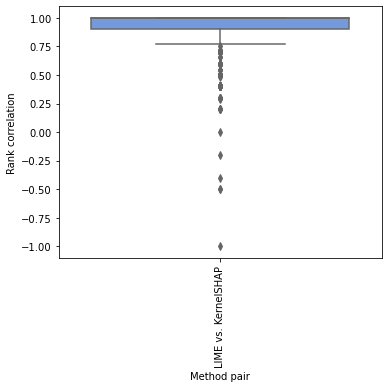

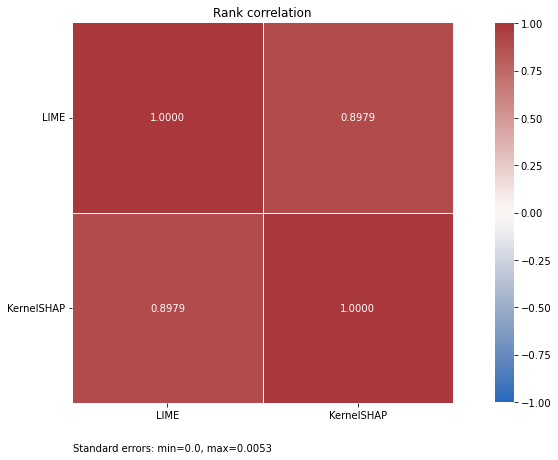

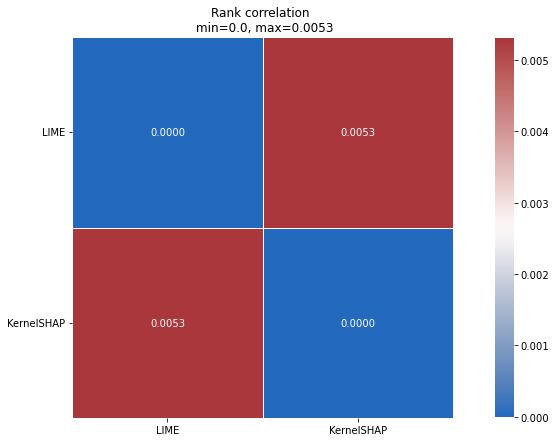

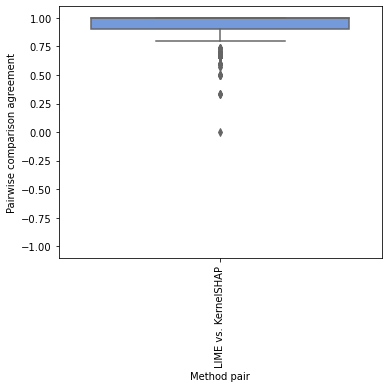

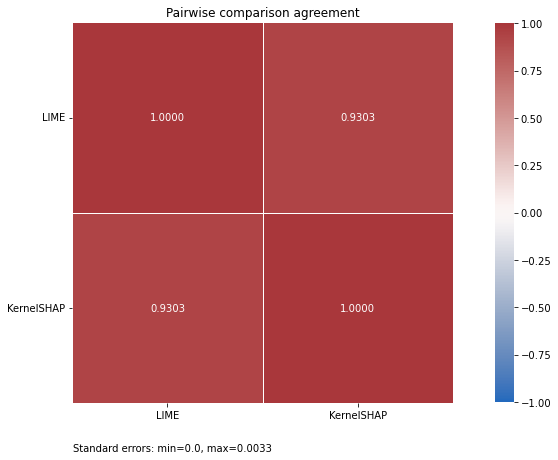

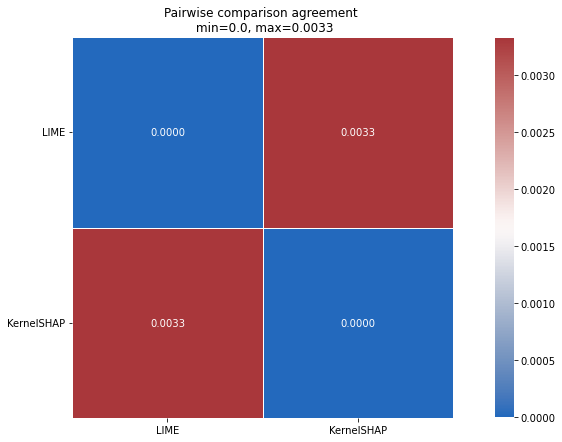

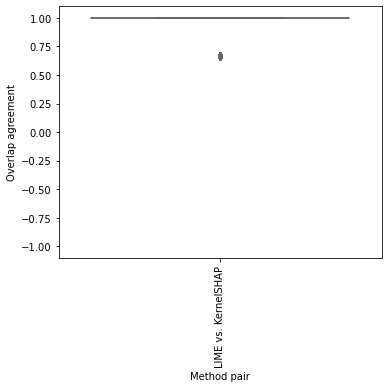

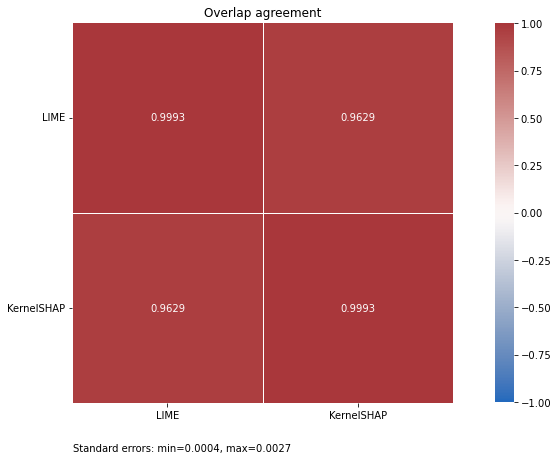

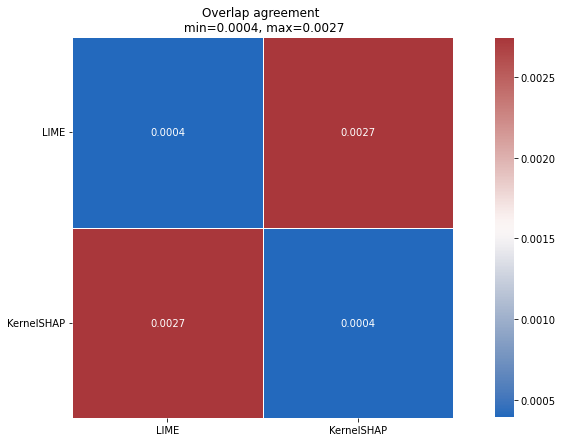

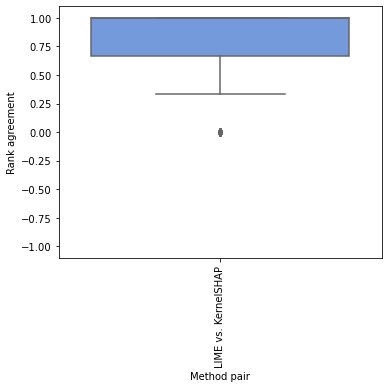

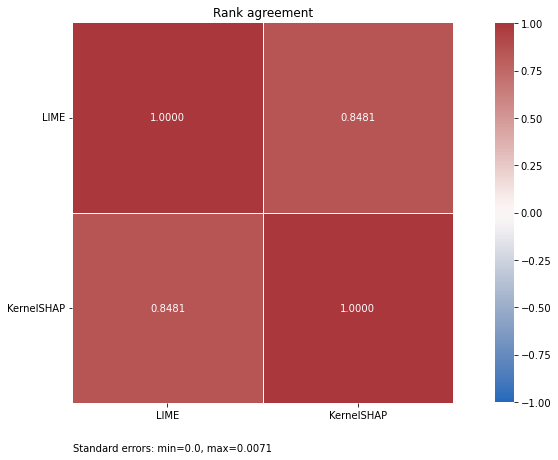

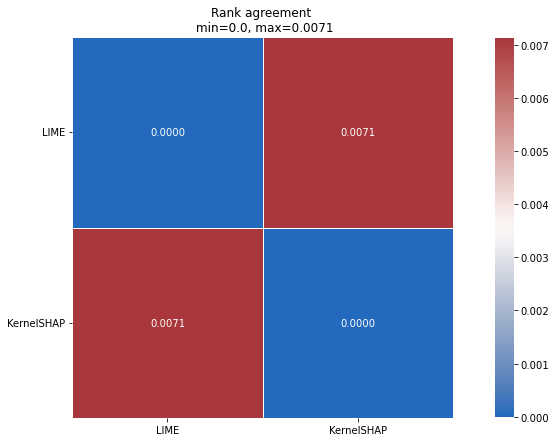

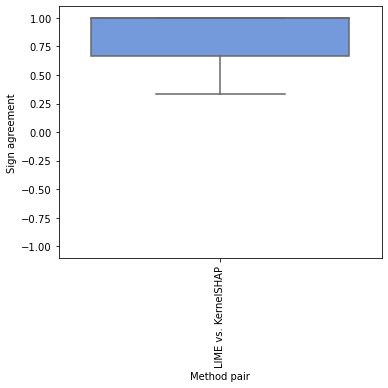

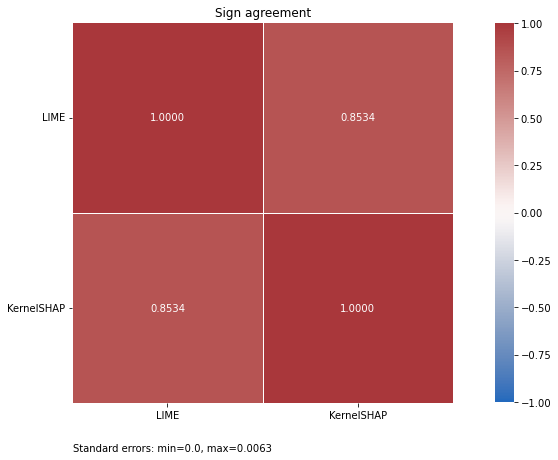

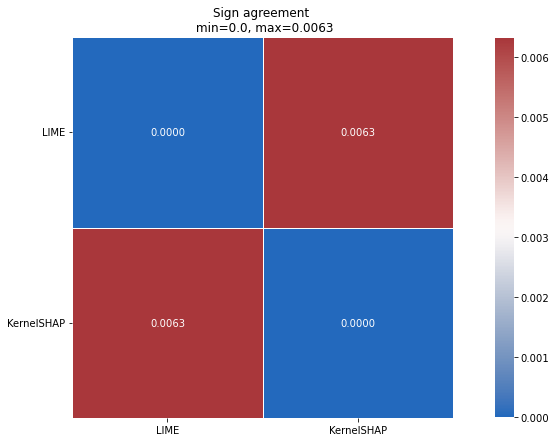

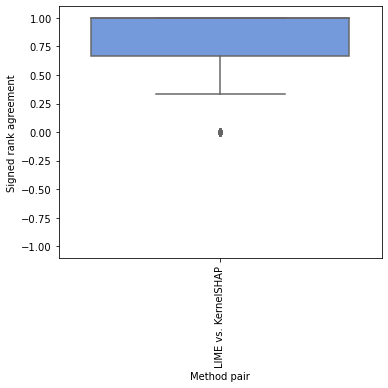

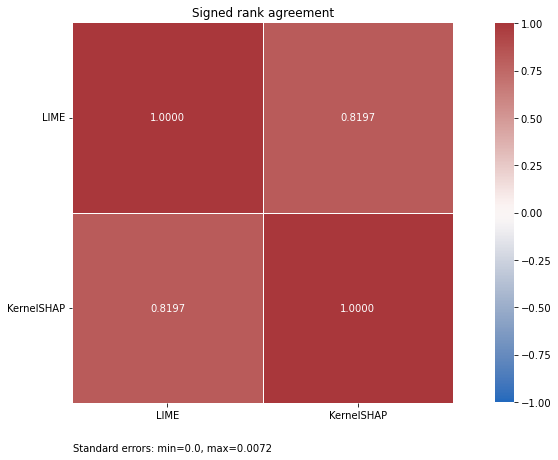

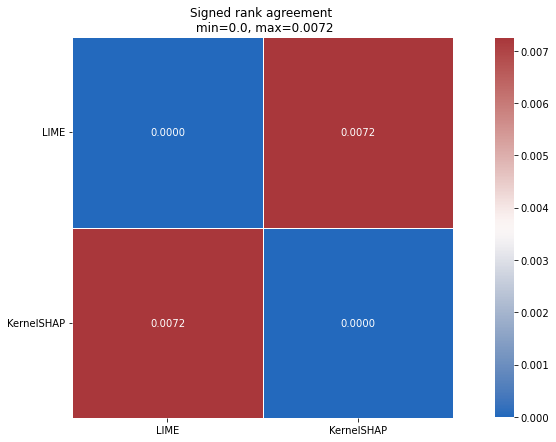

In [15]:
#logistic + nn models
expl_methods_names = {0: 'LIME',
                1: 'KernelSHAP'}

models_list = ['nn']
metrics_list = ['rankcorr', 'pairwise', 'overlap', 'rank', 'sign', 'ranksign' ] #['overlap', 'rank', 'sign', 'ranksign' ] #, 'pairwise', 'overlap', 'rank', 'sign', 'ranksign']
ks_list = [3]

for model in models_list:
    expl_methods_attrs = {0: lime_exs,
                          1: shap_exs}

    for metric in metrics_list:
        print(f'----------- calculating: {model}, {metric} -----------')
        if metric in ['overlap', 'rank', 'sign', 'ranksign']:
            for k in ks_list:
                print(f'k={k}')
                method_pairs_distr, method_pairs_avg, method_pairs_sem = metric_analysis(expl_methods_names, expl_methods_attrs, k, f'figures/{model}', metric)
        else:
            k=0 #arbitrary: these metrics (rankcorr and pairwise) don't use k
            method_pairs_distr, method_pairs_avg, method_pairs_sem = metric_analysis(expl_methods_names, expl_methods_attrs, k, f'figures/{model}', metric)    